<a href="https://colab.research.google.com/github/RockhoRockho/Deep_Learning_Tensorflow/blob/main/_6_3_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%A0%84%EC%9D%B4_%ED%95%99%EC%8A%B5_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [2]:
vgg16 = VGG16(weights='imagenet',
              input_shape=(32, 32, 3), include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [3]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

In [4]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)

resnet50 = ResNet50(weights=None, input_shape=None, include_top=True)

xception = Xception(weights=None, input_shape=None, include_top=True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#### 데이터 로드

In [17]:
!wget --no-check-certificate \
  http://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
  /content/cats_and_dogs_filtered.zip

--2021-12-14 06:50:37--  http://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   291MB/s    in 0.2s    

2021-12-14 06:50:38 (291 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [18]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [19]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [21]:
train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [22]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

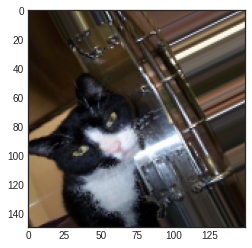

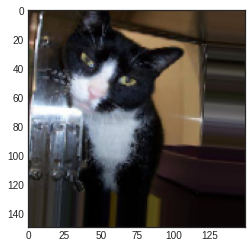

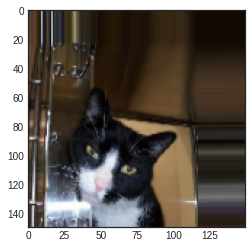

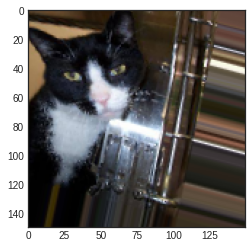

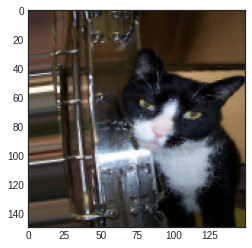

In [24]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

#### 학습, 검증 데이터셋의 Data Generator

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)     

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [29]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 28s - loss: 0.6972 - acc: 0.4855 - val_loss: 0.6912 - val_acc: 0.5880 - 28s/epoch - 277ms/step
Epoch 2/30
100/100 - 18s - loss: 0.6908 - acc: 0.5325 - val_loss: 0.6824 - val_acc: 0.5520 - 18s/epoch - 177ms/step
Epoch 3/30
100/100 - 18s - loss: 0.6785 - acc: 0.5660 - val_loss: 0.6629 - val_acc: 0.5910 - 18s/epoch - 175ms/step
Epoch 4/30
100/100 - 17s - loss: 0.6674 - acc: 0.5680 - val_loss: 0.6756 - val_acc: 0.5380 - 17s/epoch - 175ms/step
Epoch 5/30
100/100 - 18s - loss: 0.6598 - acc: 0.5885 - val_loss: 0.6319 - val_acc: 0.6600 - 18s/epoch - 180ms/step
Epoch 6/30
100/100 - 18s - loss: 0.6439 - acc: 0.6220 - val_loss: 0.6062 - val_acc: 0.6510 - 18s/epoch - 176ms/step
Epoch 7/30
100/100 - 17s - loss: 0.6292 - acc: 0.6270 - val_loss: 0.6018 - val_acc: 0.6790 - 17s/epoch - 172ms/step
Epoch 8/30
100/100 - 18s - loss: 0.6131 - acc: 0.6705 - val_loss: 0.5899 - val_acc: 0.6900 - 18s/epoch - 175ms/step
Epoch 9/30
100/100 - 17s - loss: 0.5922 - acc: 0.6865 - val_loss: 0.5670

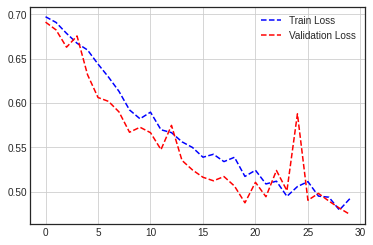

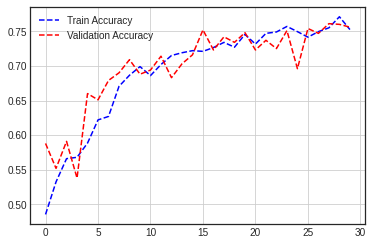

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [31]:
model.save("cats_and_dogs_model.h5")

### 사전 훈련된 모델 사용

In [32]:
conv_base = VGG16(weights='imagenet',
                  input_shape=(150, 150, 3), include_top=False)

In [35]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=2e-5),
                metrics=['accuracy'])
  
  return model

파라미터의 수 확인!

In [36]:
model = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [37]:
print(len(model.trainable_weights))

4


In [39]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [41]:
model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=2e-5),
                metrics=['accuracy'])

#### 이미지 제너레이터

In [42]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [44]:
history2 = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 19s - loss: 0.6083 - accuracy: 0.6745 - val_loss: 0.4801 - val_accuracy: 0.8020 - 19s/epoch - 186ms/step
Epoch 2/30
100/100 - 18s - loss: 0.4948 - accuracy: 0.7705 - val_loss: 0.3894 - val_accuracy: 0.8400 - 18s/epoch - 183ms/step
Epoch 3/30
100/100 - 18s - loss: 0.4438 - accuracy: 0.8030 - val_loss: 0.3501 - val_accuracy: 0.8470 - 18s/epoch - 183ms/step
Epoch 4/30
100/100 - 18s - loss: 0.4101 - accuracy: 0.8155 - val_loss: 0.3237 - val_accuracy: 0.8560 - 18s/epoch - 178ms/step
Epoch 5/30
100/100 - 18s - loss: 0.3883 - accuracy: 0.8360 - val_loss: 0.3137 - val_accuracy: 0.8610 - 18s/epoch - 176ms/step
Epoch 6/30
100/100 - 18s - loss: 0.3661 - accuracy: 0.8455 - val_loss: 0.3000 - val_accuracy: 0.8660 - 18s/epoch - 175ms/step
Epoch 7/30
100/100 - 17s - loss: 0.3619 - accuracy: 0.8445 - val_loss: 0.3022 - val_accuracy: 0.8680 - 17s/epoch - 175ms/step
Epoch 8/30
100/100 - 18s - loss: 0.3417 - accuracy: 0.8555 - val_loss: 0.2874 - val_accuracy: 0.8690 - 18s/epoch - 176

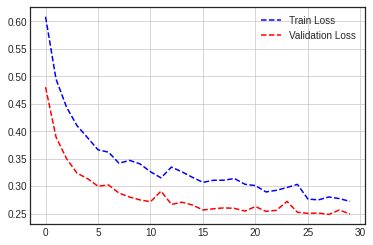

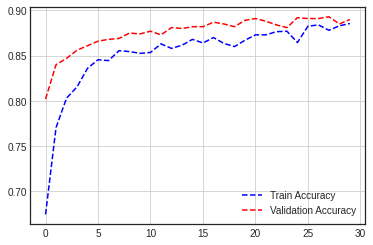

In [48]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [49]:
model.save('cats_and_digs_with_pretrained_model.h5')

## Feature Map 시각화

In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

### 모델 구성

In [51]:
model = load_model('/content/cats_and_dogs_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)     

In [58]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255
print(img_tensor.shape)

(1, 150, 150, 3)


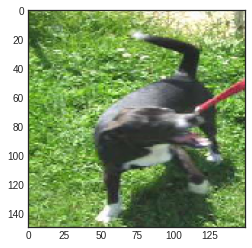

In [59]:
plt.imshow(img_tensor[0])
plt.show()

In [60]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_4')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_5')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_6')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_7')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_3')>]

In [61]:
activation_model = Model(inputs=[model.input], outputs=conv_output)

In [62]:
activations = activation_model.predict(img_tensor)

In [63]:
len(activations)

8

### 시각화

(1, 148, 148, 32)


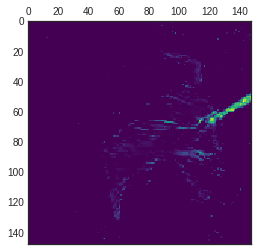

In [64]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 7], cmap='viridis')
plt.show()

(1, 148, 148, 32)


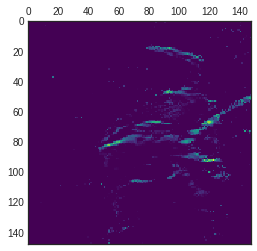

In [65]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 10], cmap='viridis')
plt.show()

(1, 148, 148, 32)


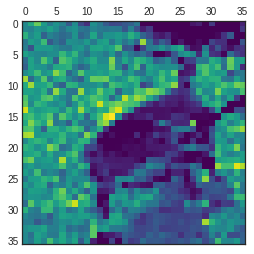

In [66]:
print(activations[0].shape)
plt.matshow(activations[3][0, :, :, 20], cmap='viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


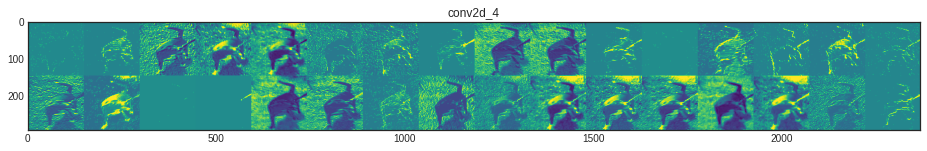

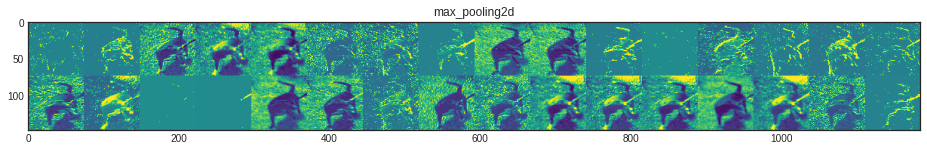

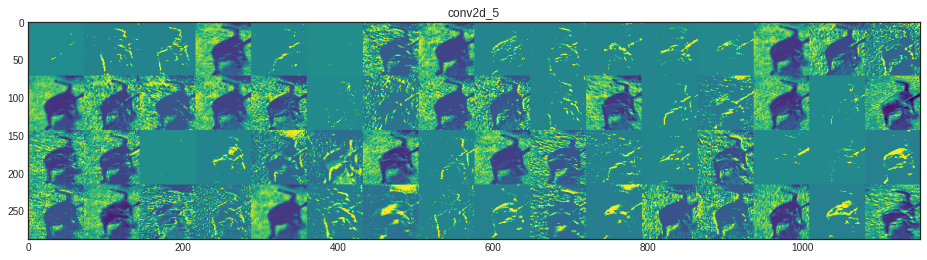

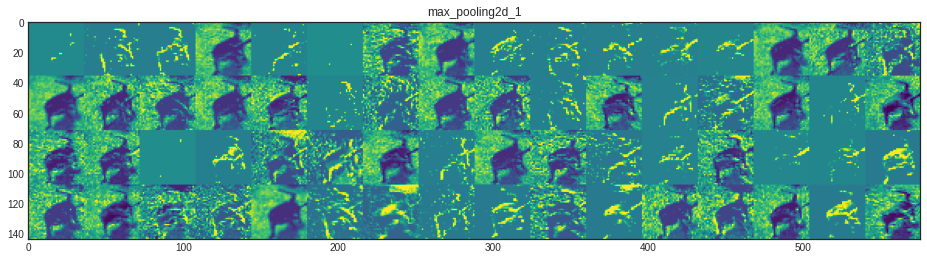

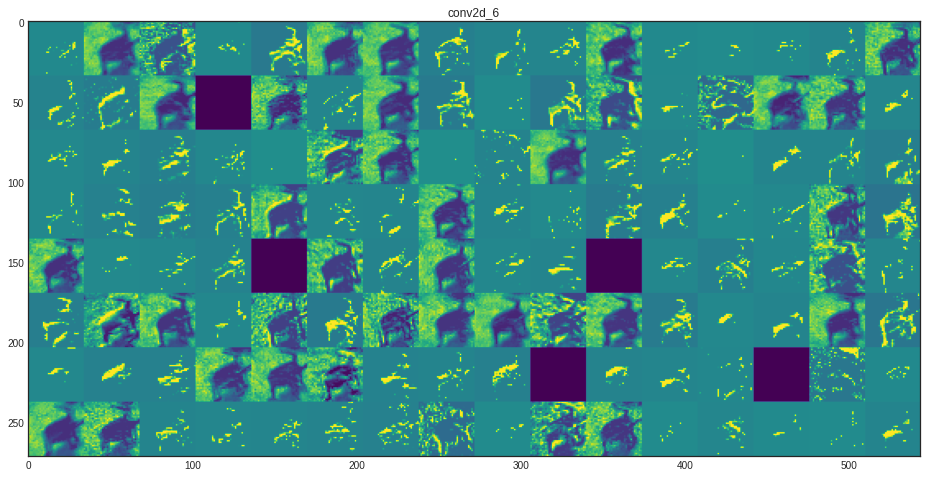

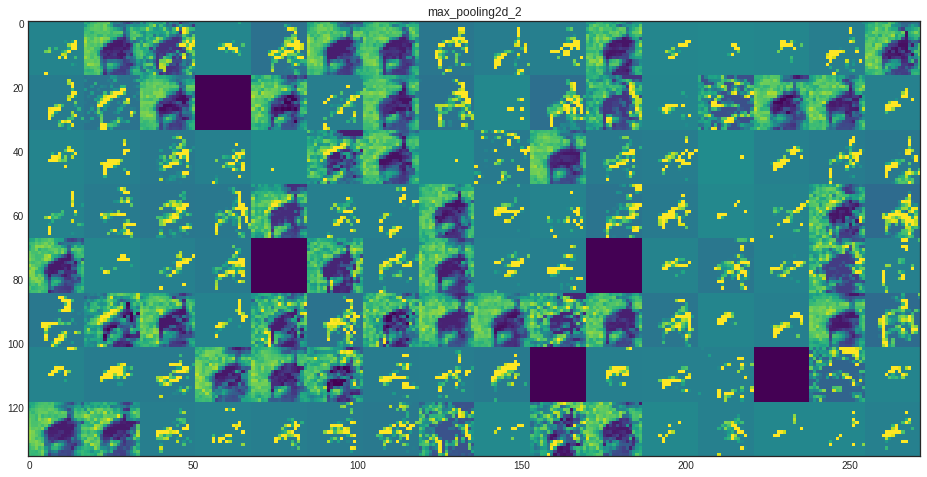

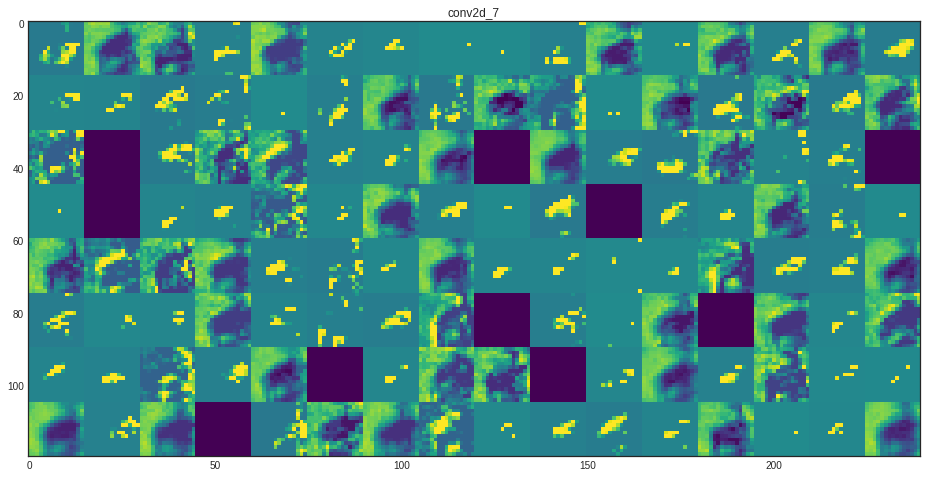

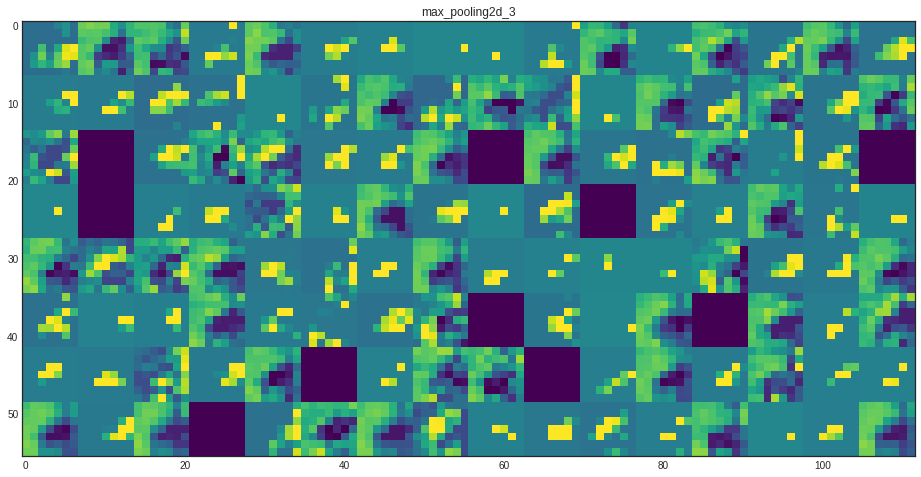

In [68]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  num_cols = num_features // images_per_row
  display_grid = np.zeros((size * num_cols, images_per_row * size))

  for col in range(num_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size: (col+1) * size, row * size : (row+1) * size] = channel_image

  scale = 1. / size

  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()